In [1]:
import os, sys, re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import convolve2d
sys.path.append("../lib")
from kernel import *

In [2]:
field = "Blind15A_16"
CCD = "N8"

In [3]:
stardir = "../stars"
files = os.listdir(stardir)
pattern = re.compile("%s_%s_(.*?)_stars.npy*" % (field, CCD))
selfiles = []
epochs = []
stars = {}
for f in files:
    if pattern.match(f):
        selfiles.append(f)
        epochs.append(pattern.findall(f)[0]) 
        stars[epochs[-1]] = np.load("%s/%s" % (stardir, f), encoding = "bytes")

In [4]:
# loop among all epochs
def showstars(kern, stars, allstars = False):
    
    for k in sorted(stars.keys()):
        
        if k == "ref":
            continue
            
        #if k != "02":
        #    continue
    
        print("ref", k, end = "\r")
        
        # get stars
        starpairs = np.stack([stars["ref"], stars[k]])
        _, nstars, nside, _ = np.shape(starpairs)
        npsf = nside - kern.nf
        nfh = int(kern.nf / 2)
        
        # create array with pairs of stars
        pairs = []
        for i in range(nstars):
            if i > 0 and not allstars:
                continue
            star1 = starpairs[1][i]
            star2 = starpairs[0][i]
            pairs.append([star1, star2])
            
        # solve kernel with given pairs of stars
        sol = kern.solve(npsf, pairs)
              
        if allstars:
            fig, ax = plt.subplots(nrows = nstars, ncols = 5, figsize = (15, 25))
        else:
            fig, ax = plt.subplots(ncols = 5, figsize = (15, 3))
        
        # plot convolved stars and difference
        for i in range(nstars):
            
            if i > 0 and not allstars:
                continue
            
            star1 = starpairs[1][i]
            star2 = starpairs[0][i]
            star1conv = kern.convolve(star1)        
            diff = star2[nfh:-(nfh+1), nfh:-(nfh+1)] - star1conv 
    
            # plot solution
            if allstars:
                axi = ax[i]
            else:
                axi = ax
            axi[0].imshow(np.arcsinh(kern.solfilter/0.01), interpolation = "nearest") 
            axi[1].imshow(star1[nfh:-(nfh+1),nfh:-(nfh+1)], interpolation = "nearest") 
            axi[1].set_title("%.4f, %.4f" % (np.min(star1.flatten()), np.max(star1.flatten())), fontsize = 9)
            axi[2].imshow(star2[nfh:-(nfh+1),nfh:-(nfh+1)], interpolation = "nearest") 
            axi[2].set_title("%.4f, %.4f" % (np.min(star2.flatten()), np.max(star2.flatten())), fontsize = 9)
            axi[3].imshow(star1conv, interpolation = "nearest") 
            axi[3].set_title("%.4f, %.4f" % (np.min(star1conv.flatten()), np.max(star1conv.flatten())), fontsize = 9)
            axi[4].imshow(diff, interpolation = "nearest") 
            axi[4].set_title("%.4f, %.4f" % (np.min(diff.flatten()), np.max(diff.flatten())), fontsize = 9)
            for k in range(5):
                axi[k].axis('off')
                axi[k].axvline(npsf/2)
                axi[k].axhline(npsf/2)
                
        plt.tight_layout(pad = -1)

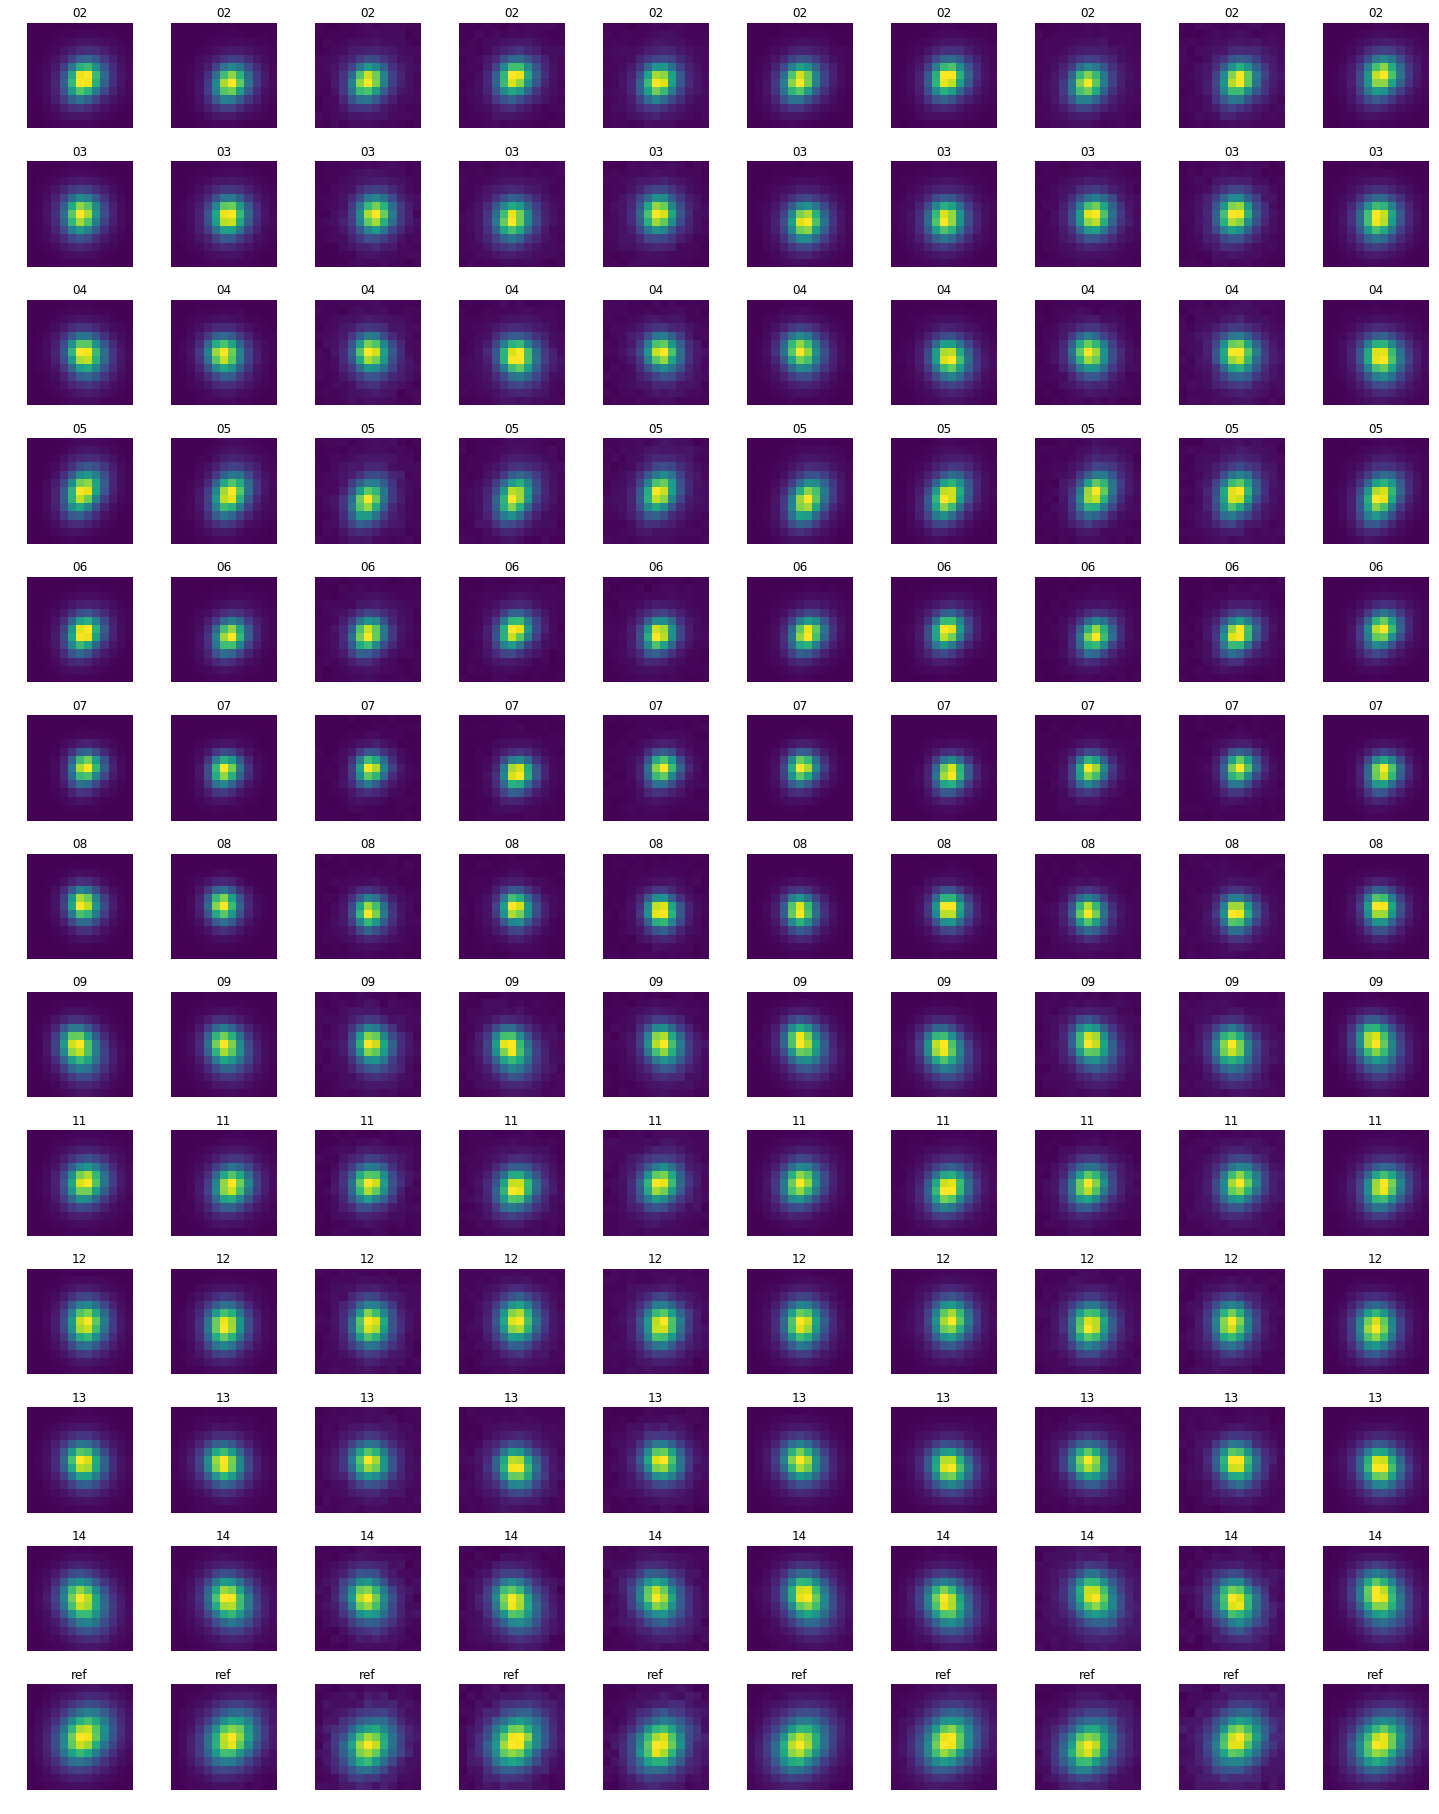

In [5]:
fig, ax = plt.subplots(nrows = len(stars.keys()), ncols = np.shape(stars["ref"])[0], figsize = (20, 25))
for ix, k in enumerate(sorted(stars.keys())):
    for iy, star in enumerate(stars[k]):
        ncut = 16
        ax[ix, iy].imshow(star[ncut:-(ncut+1), ncut:-(ncut+1)], interpolation = 'nearest')
        ax[ix, iy].axis('off')
        ax[ix, iy].set_title("%s" % k)
plt.tight_layout(pad = 0)

   Kernel initialized with filter size 25 and 81 free parameters


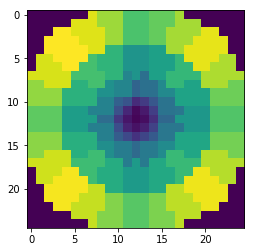

In [6]:
# start kernel object
kern = kernel(81) # 81 625
fig, ax = plt.subplots()
ax.imshow(kern.ivarf, interpolation = "nearest");

Train with one star and test with that star

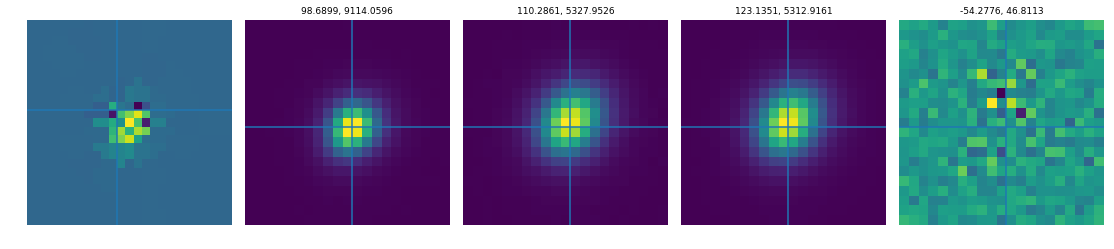

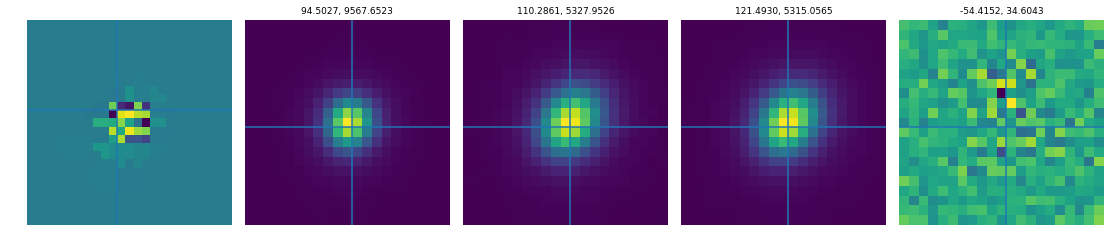

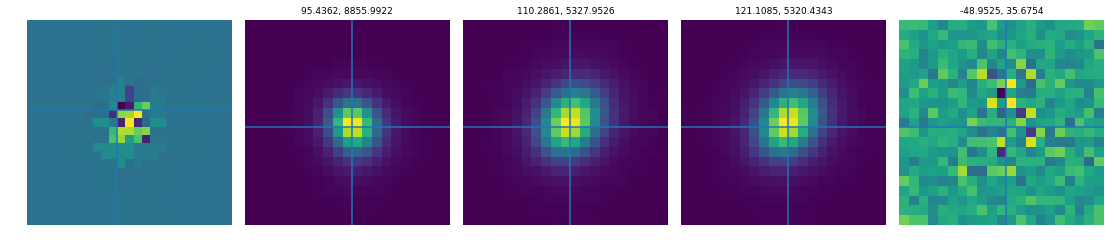

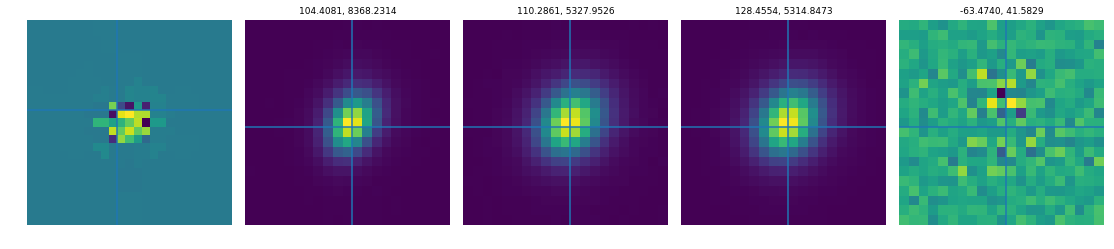

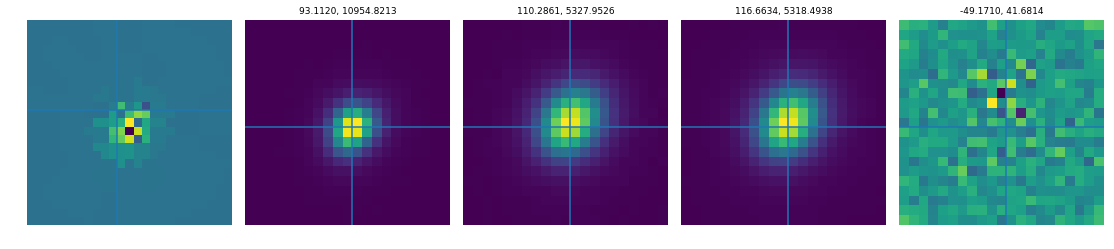

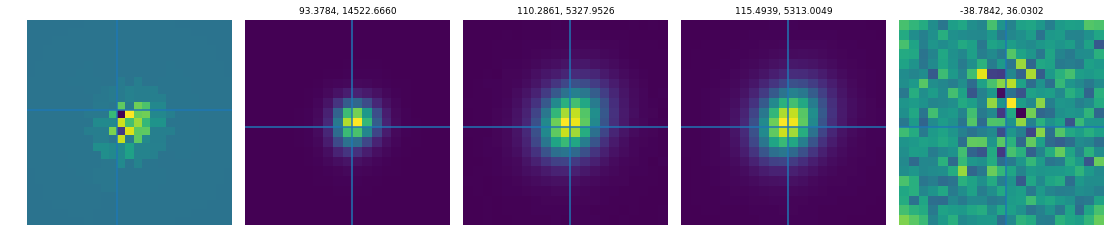

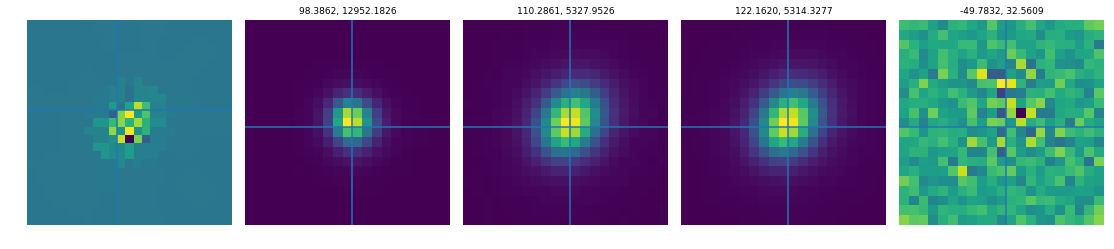

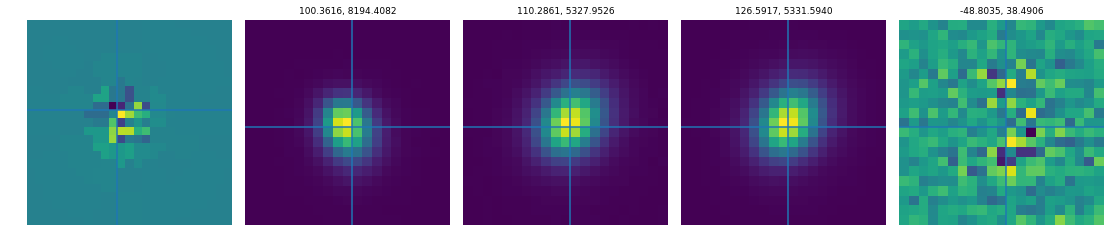

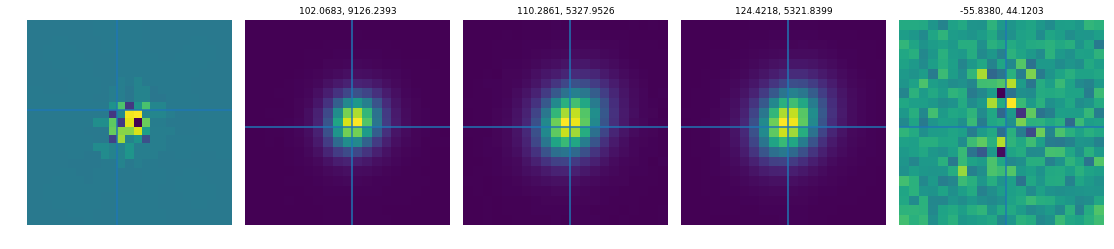

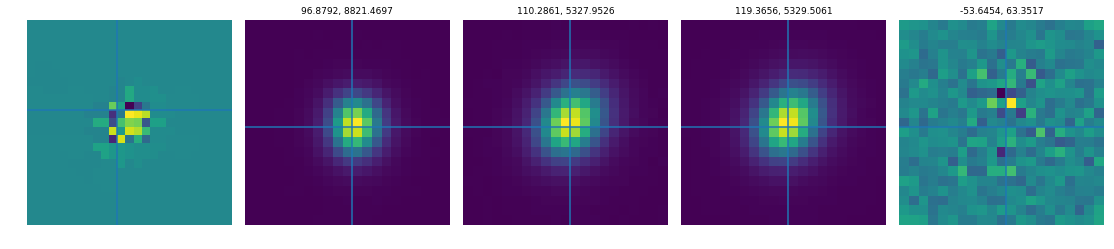

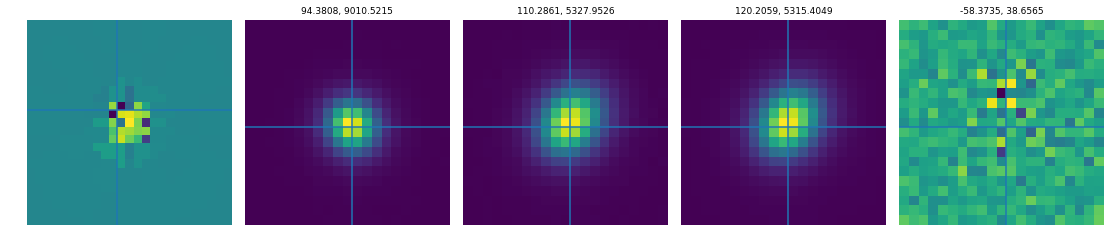

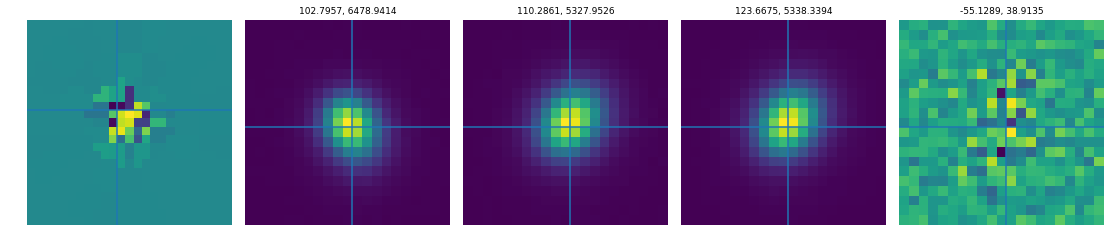

In [7]:
showstars(kern, stars, False)

Train with all stars and test with all of them. Note that dipoles are due to alignment errors

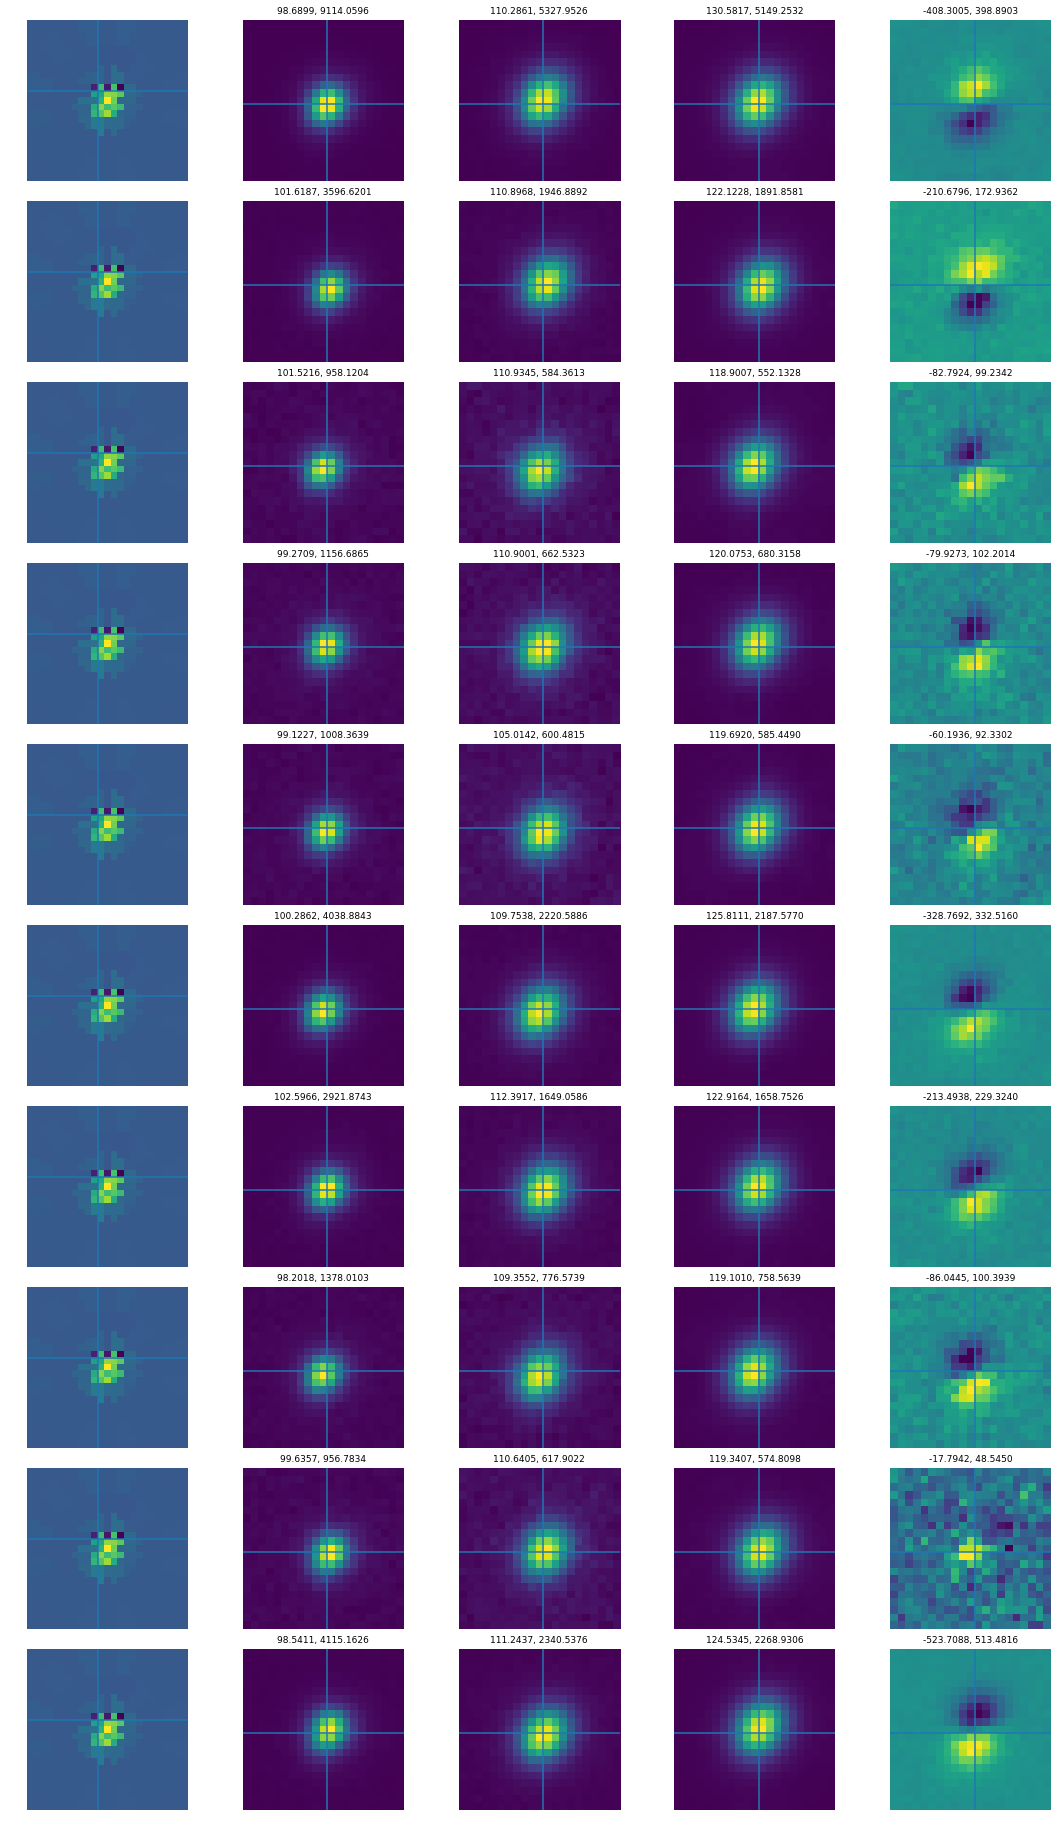

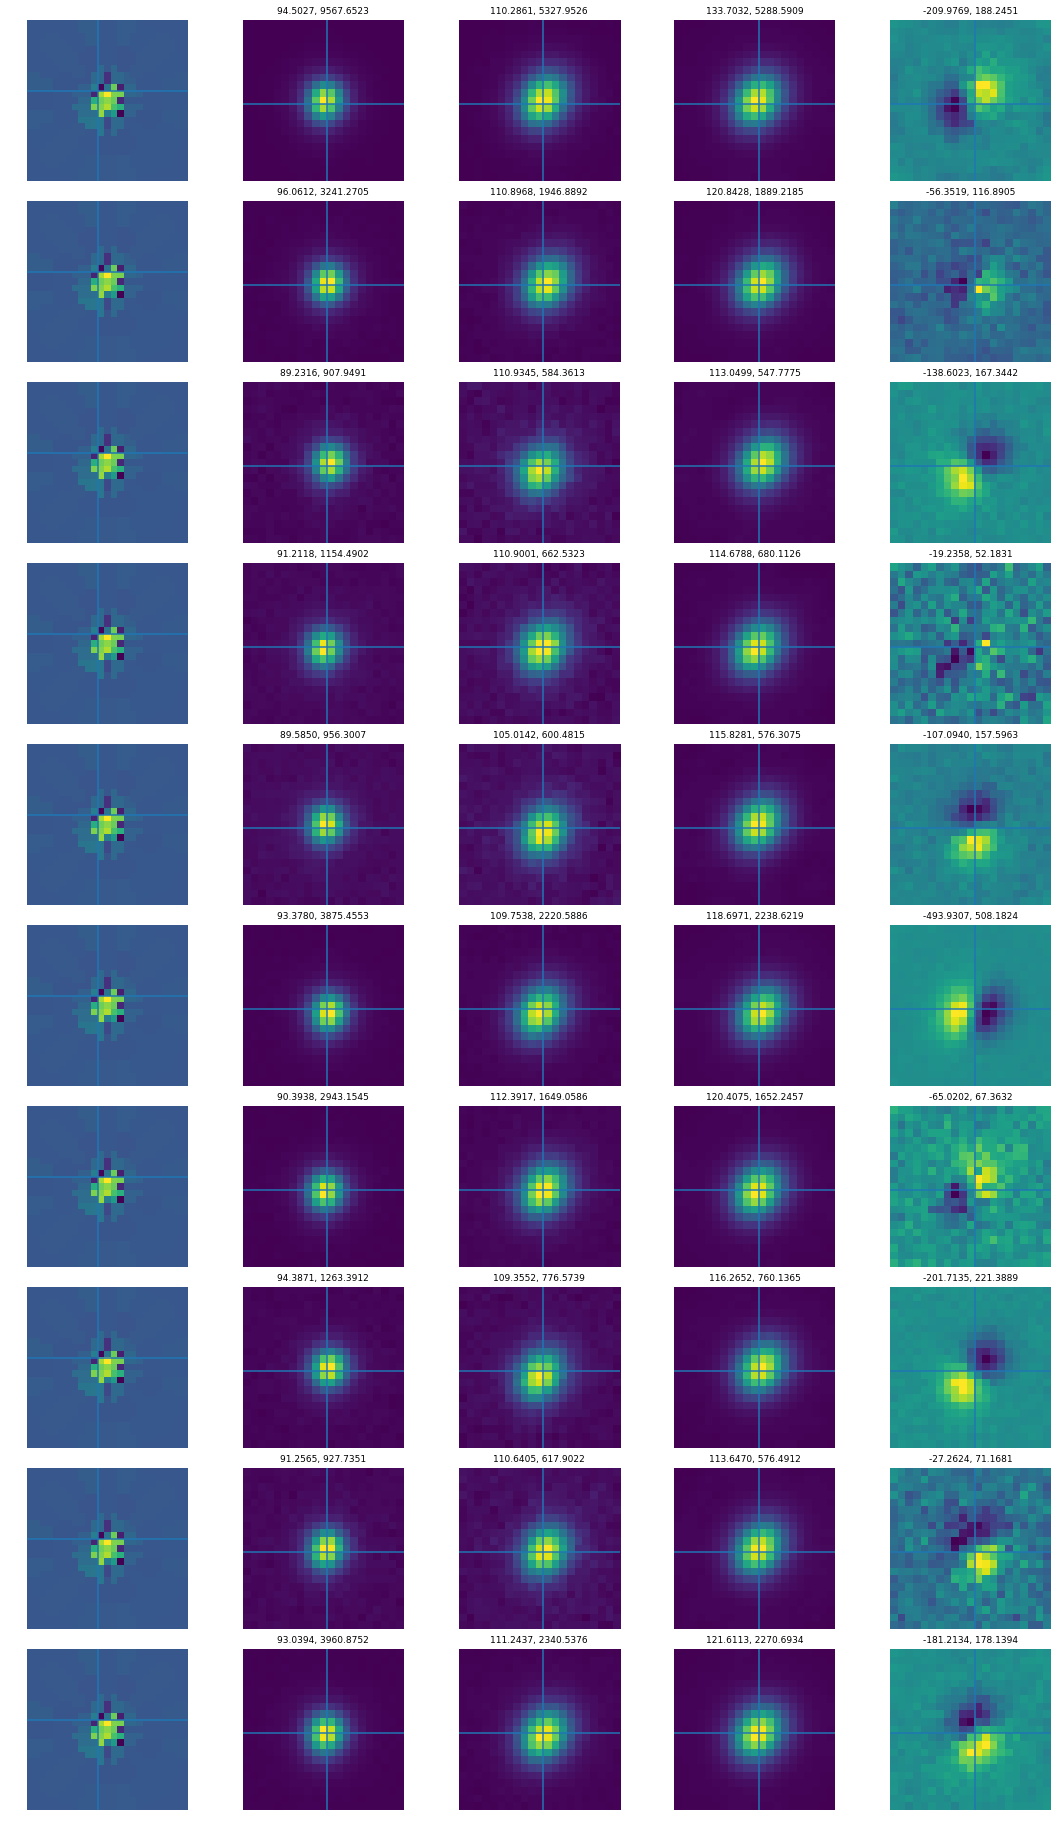

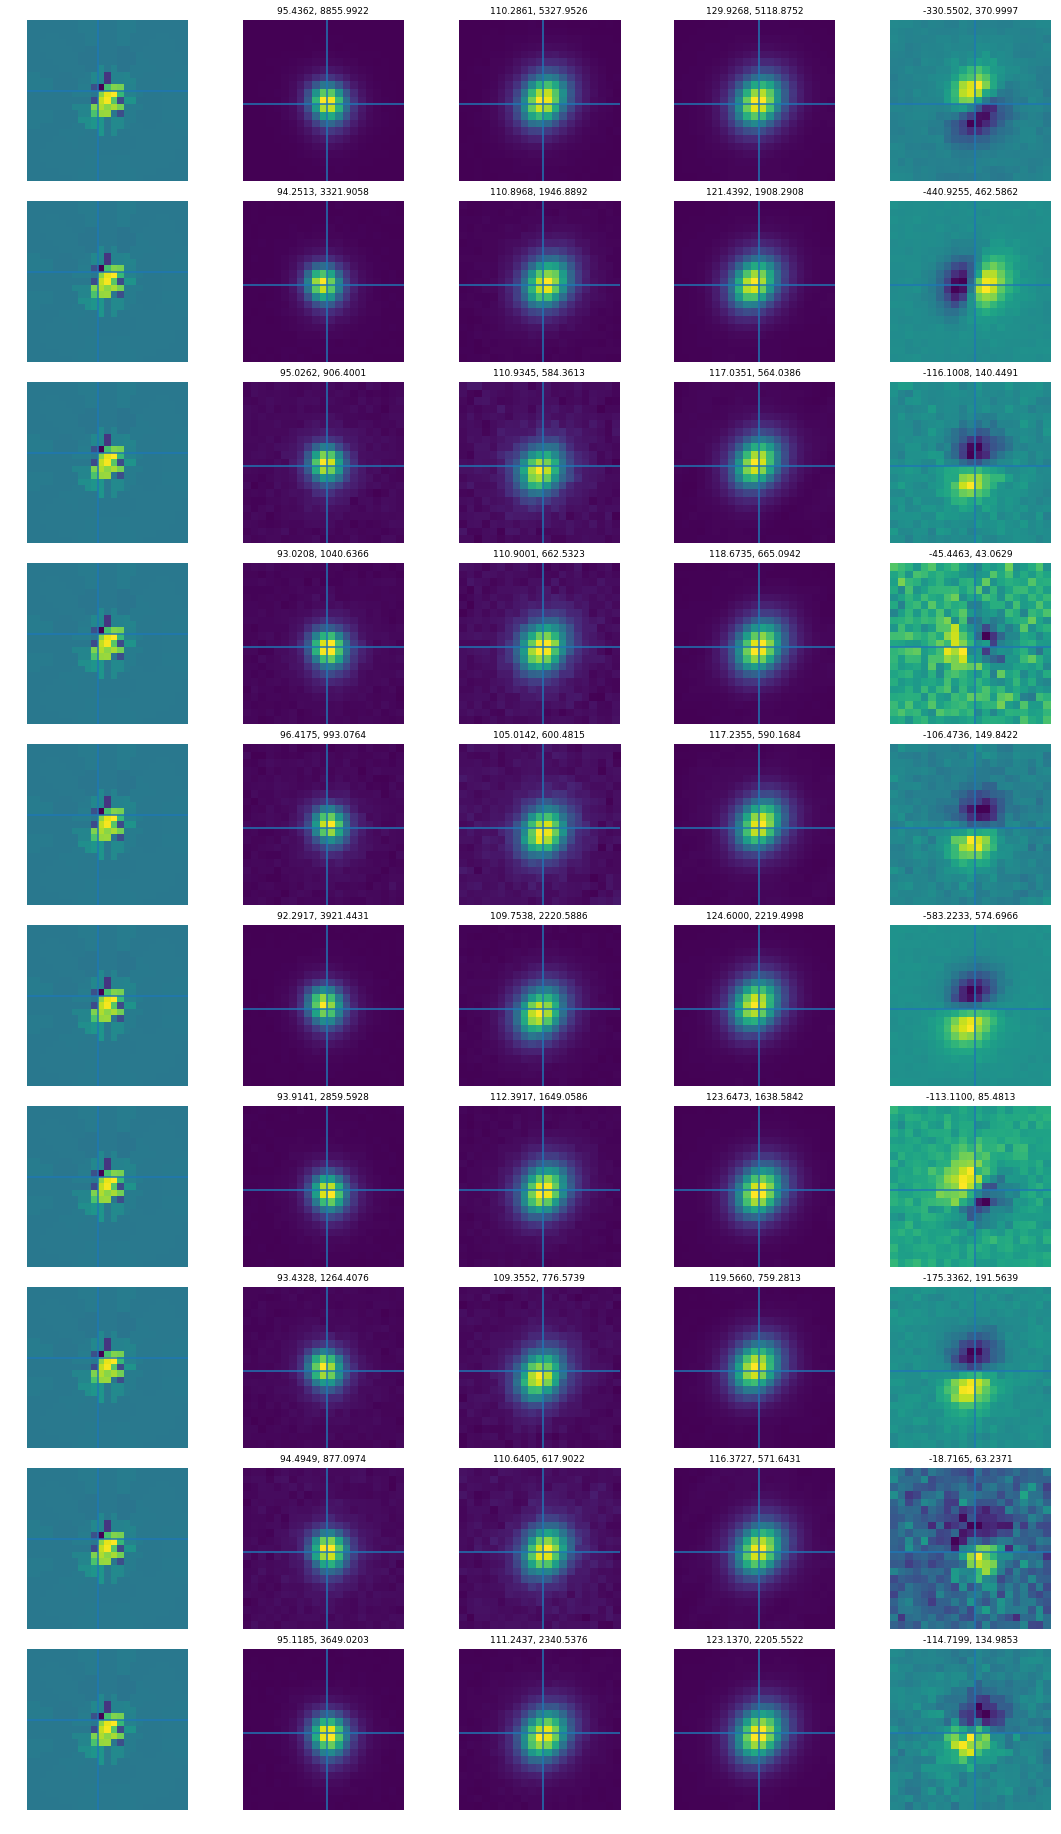

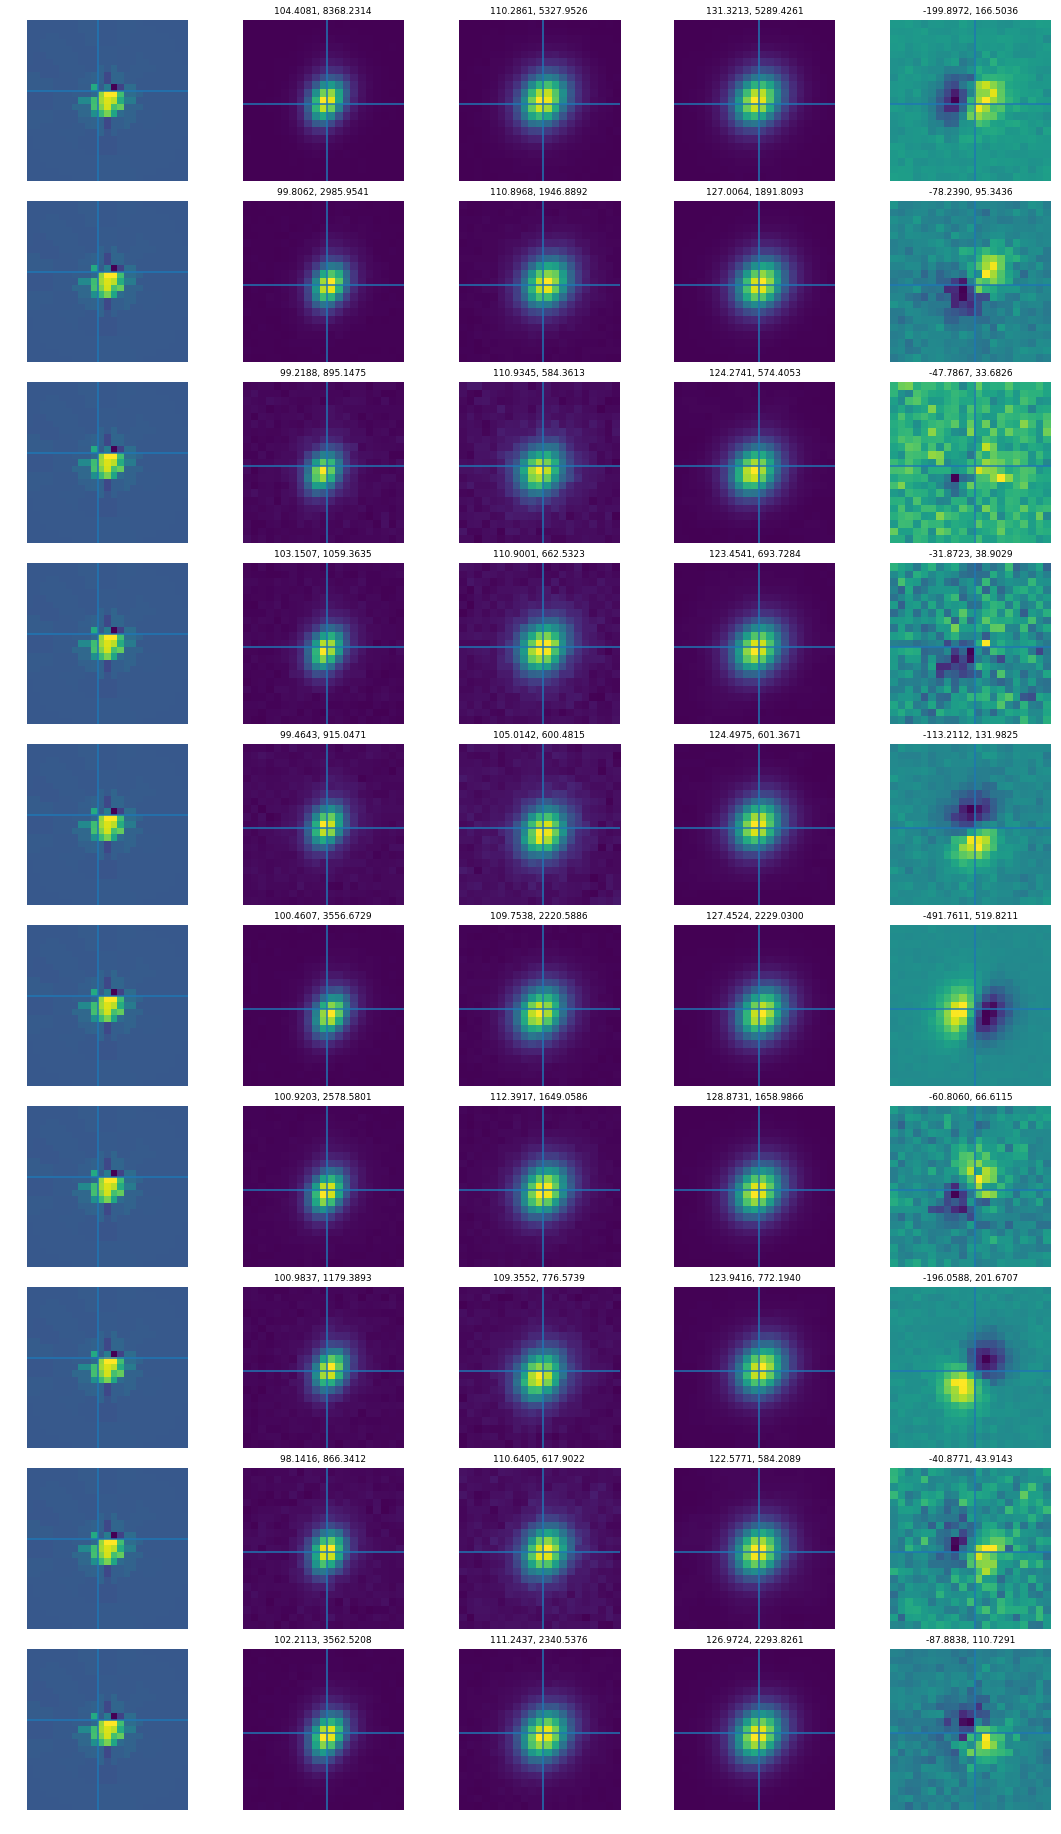

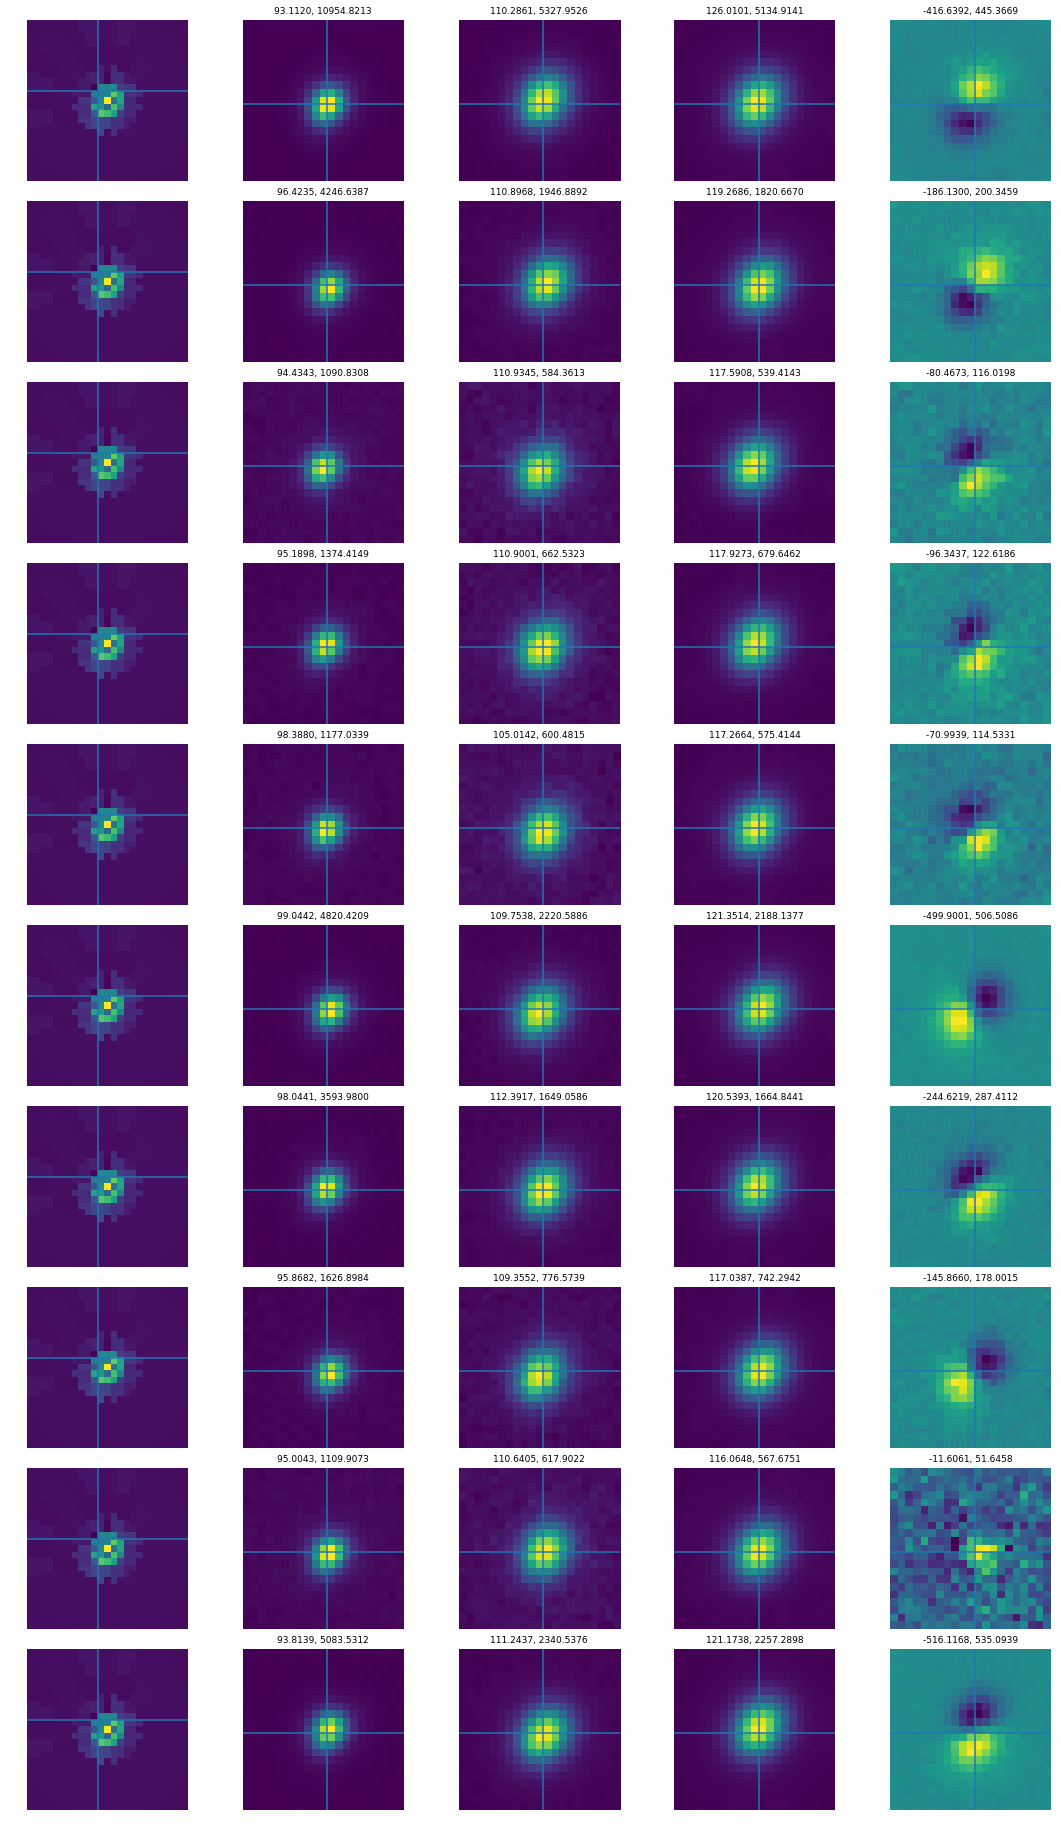

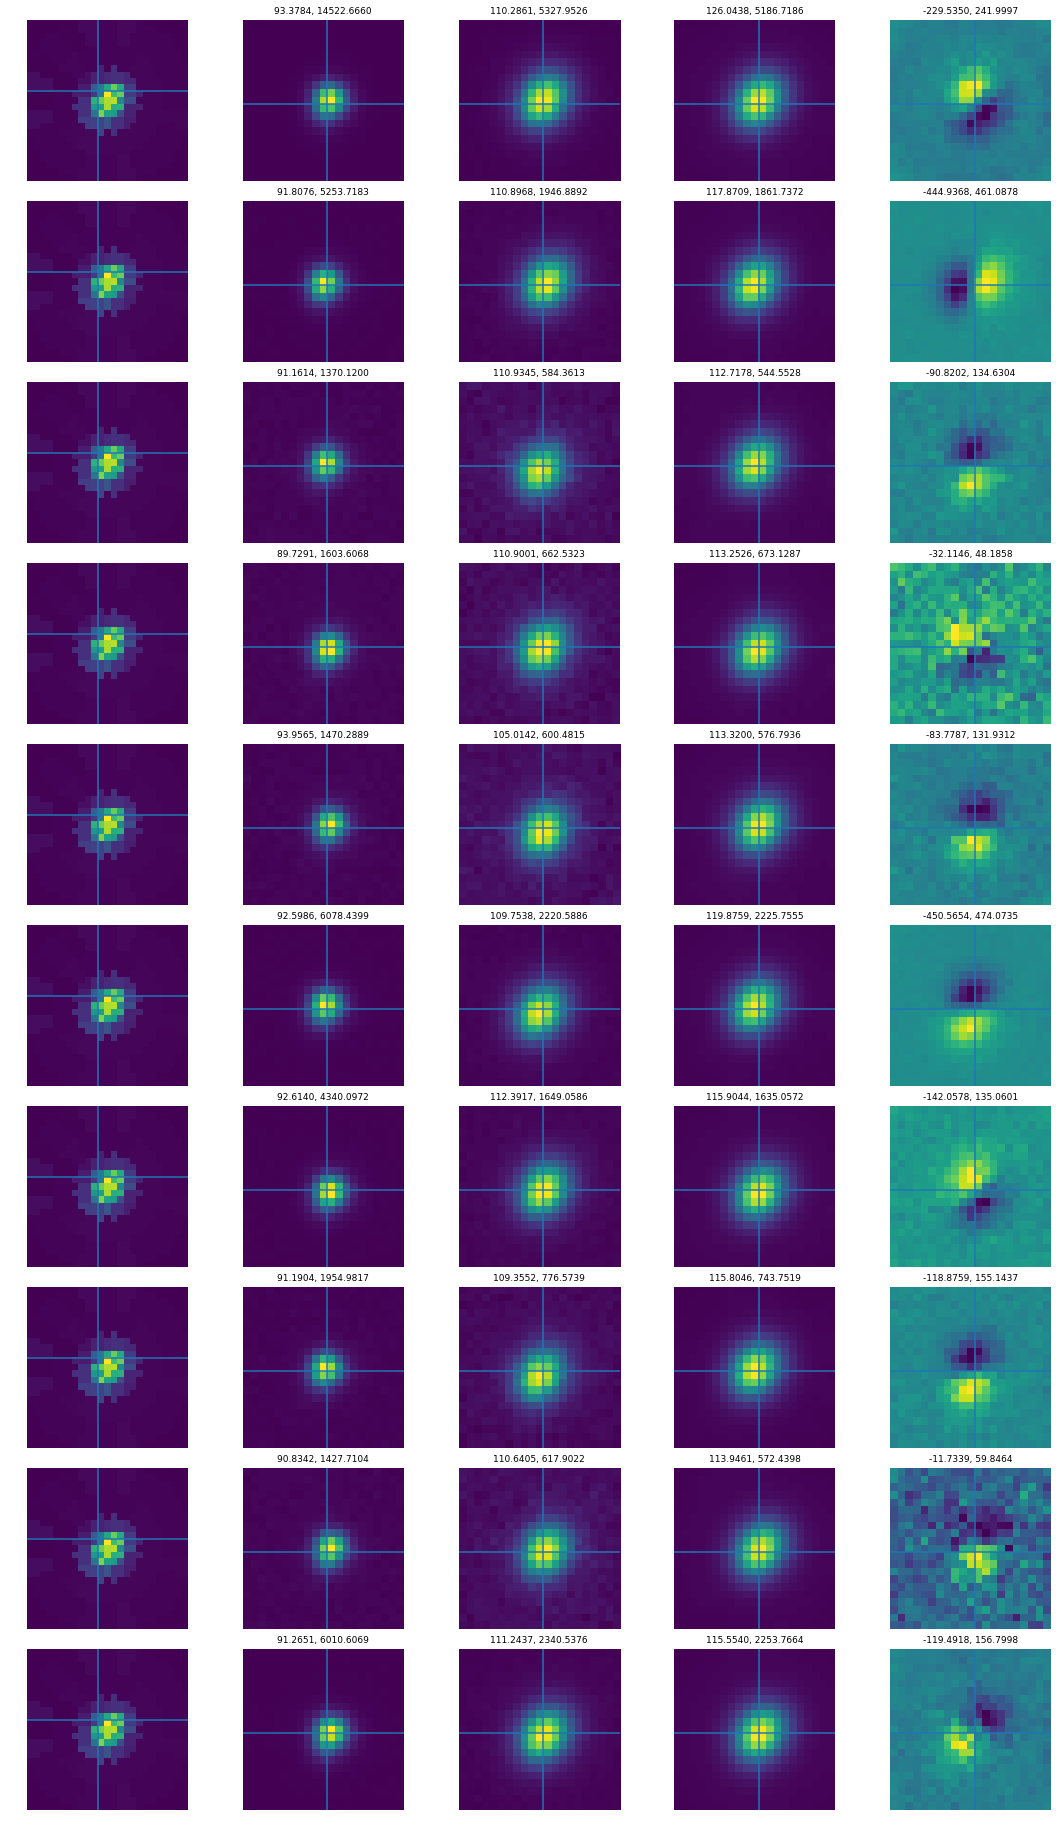

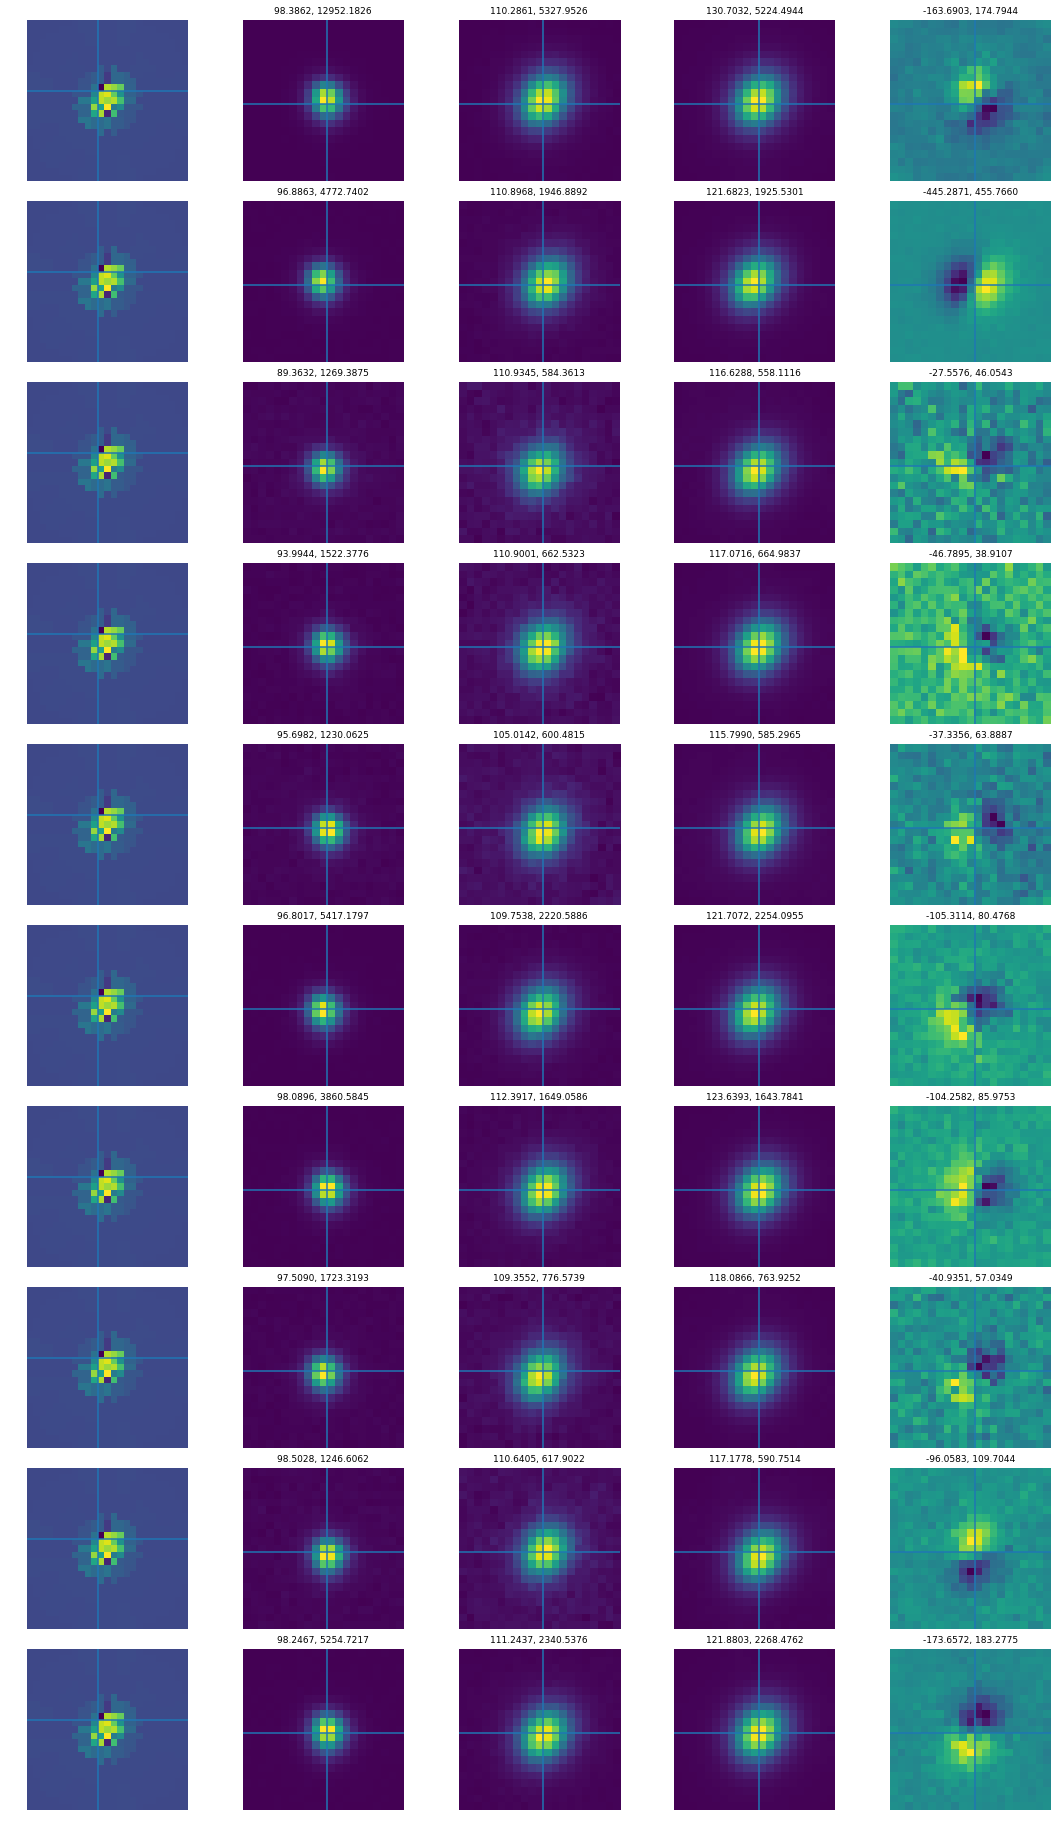

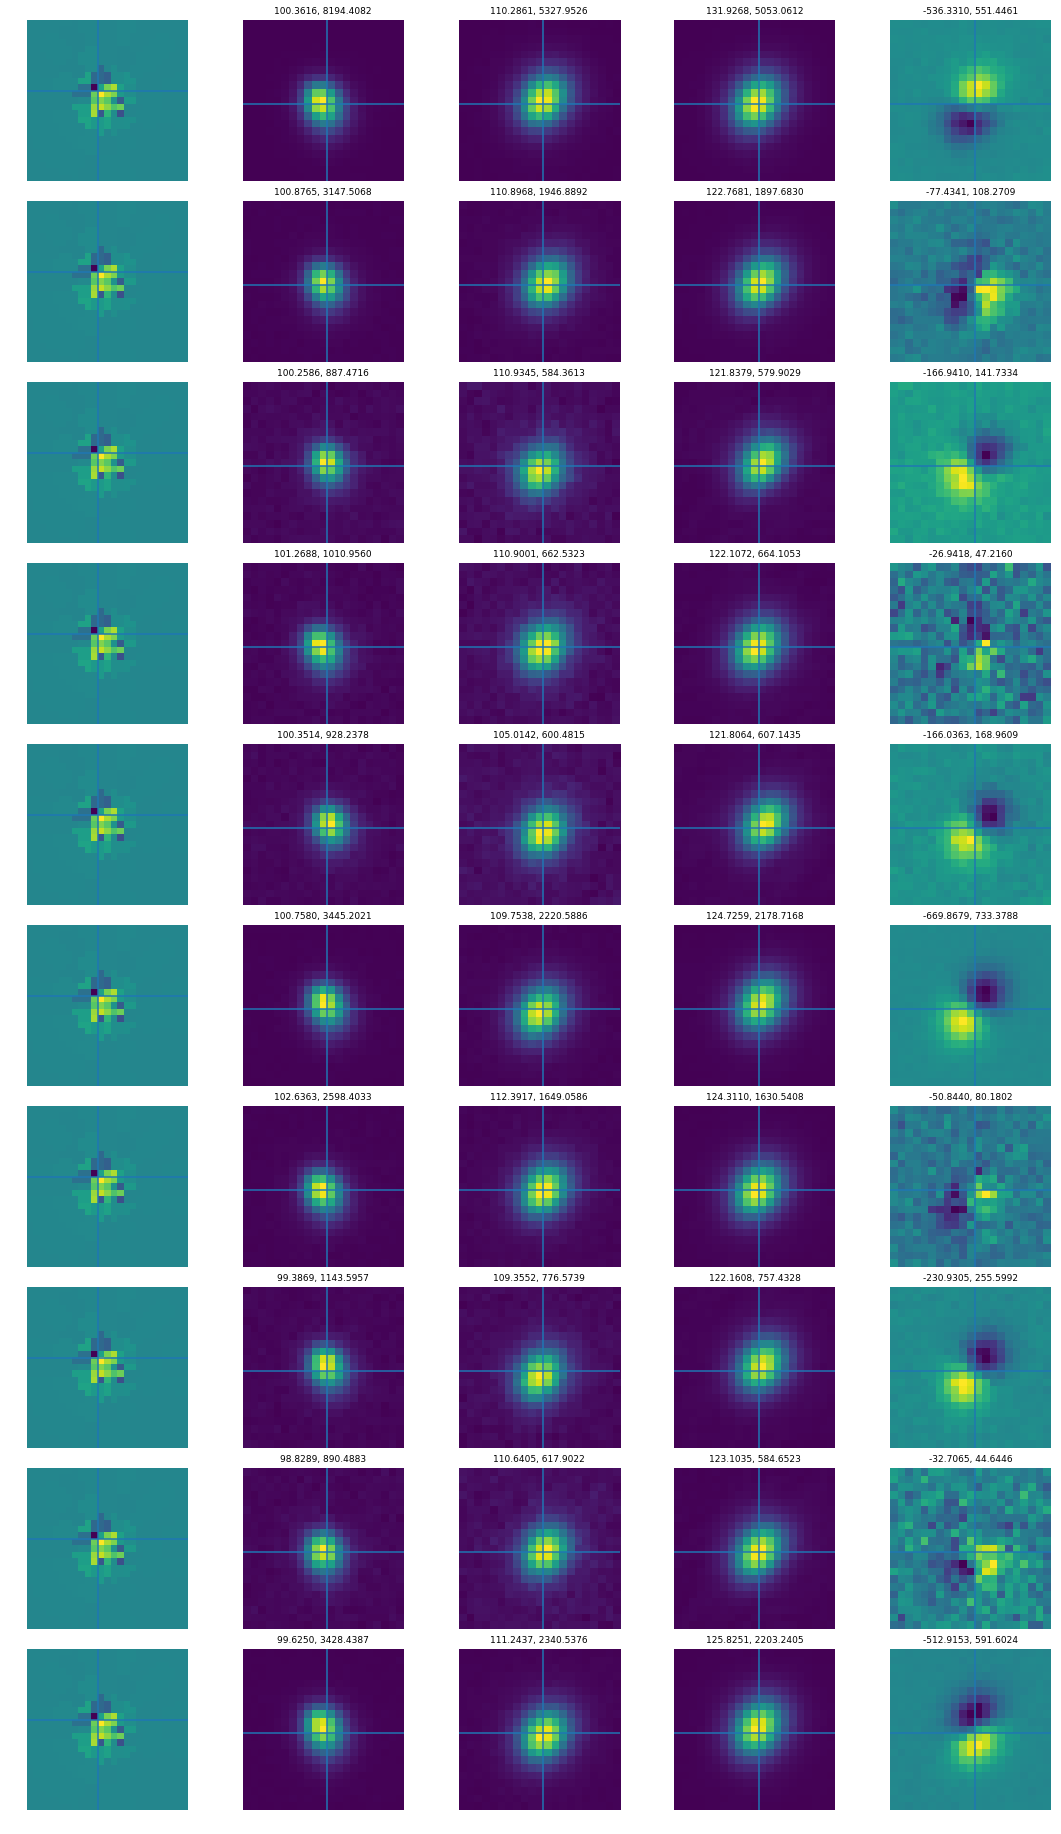

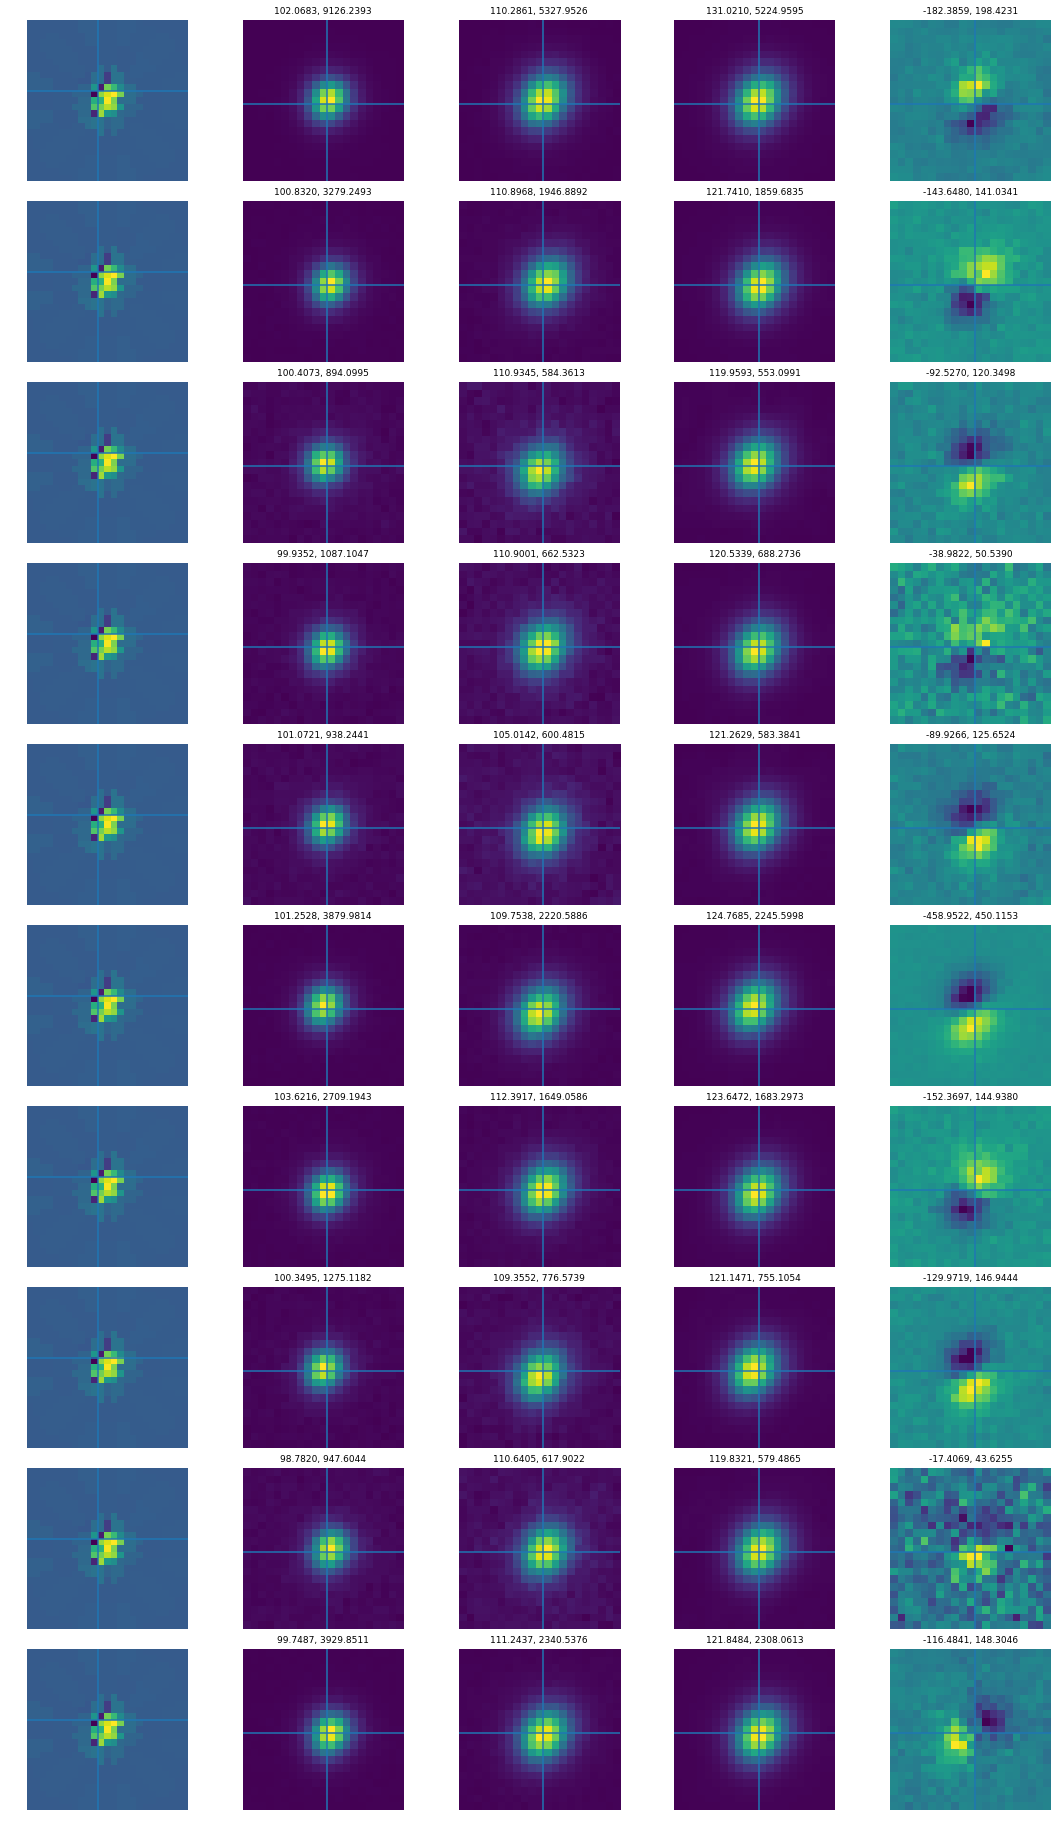

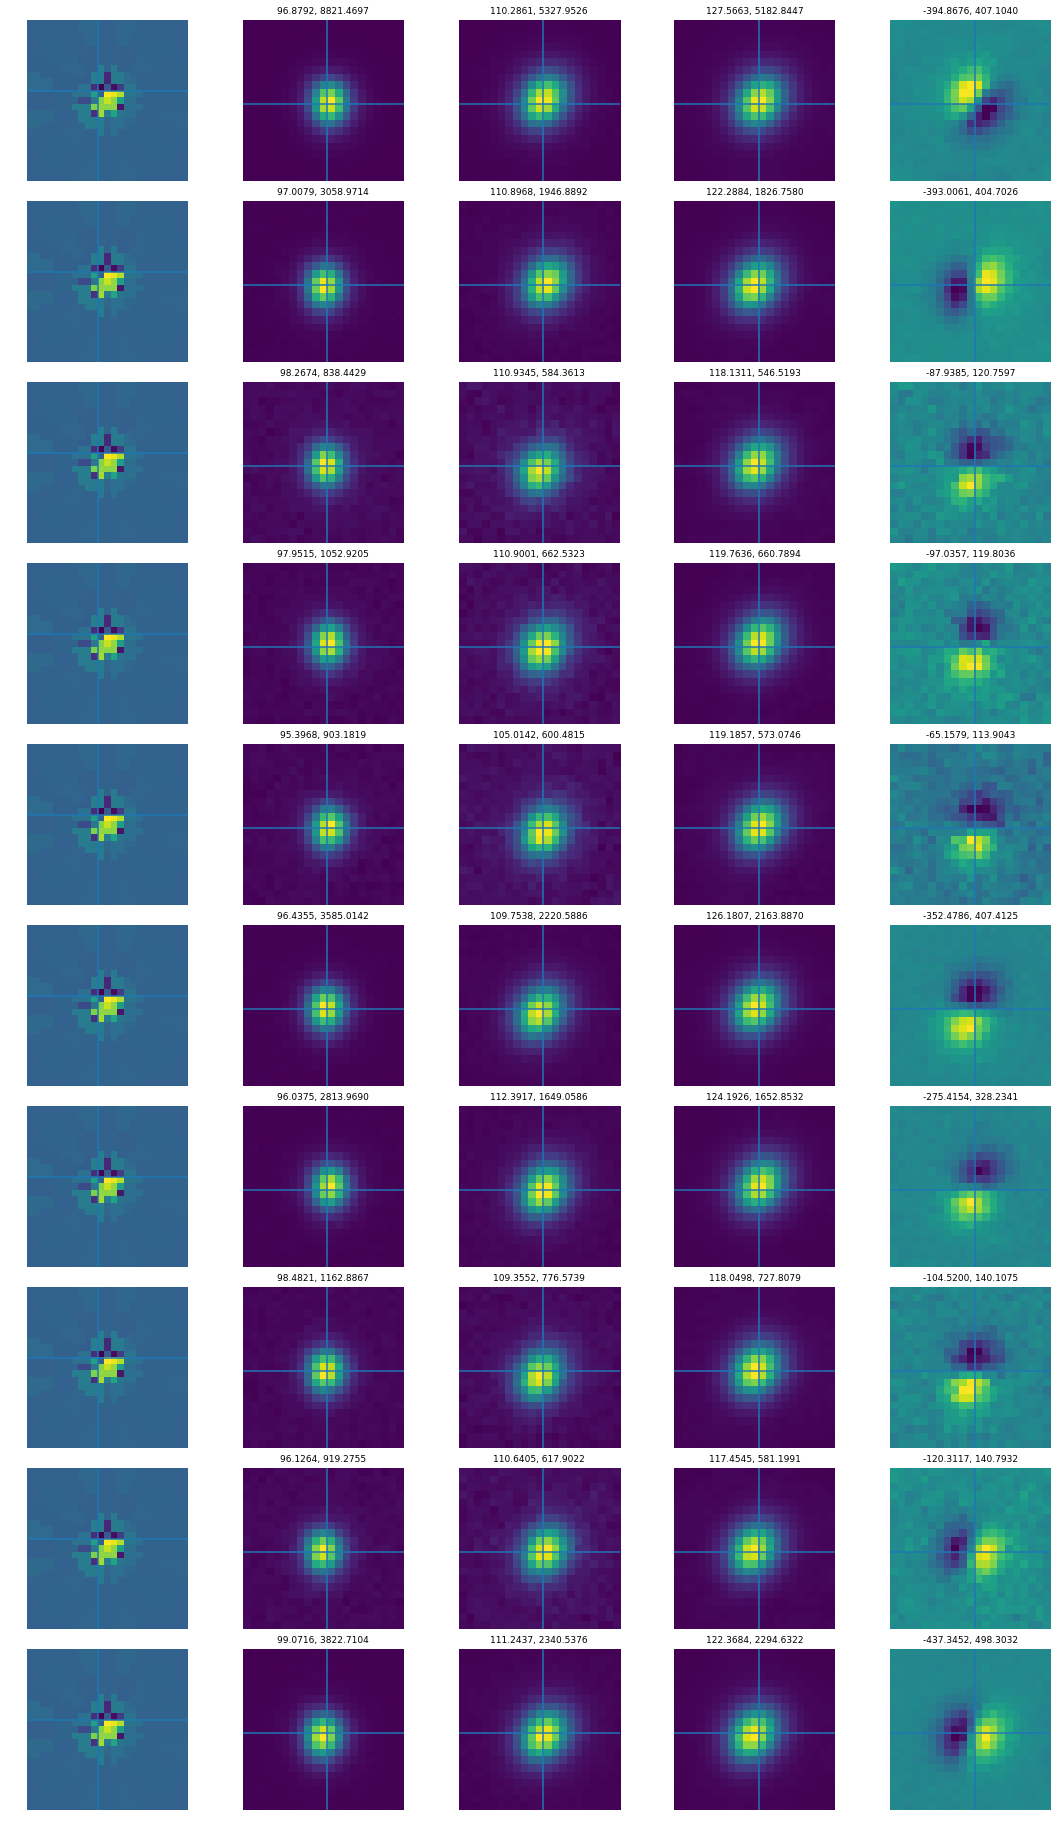

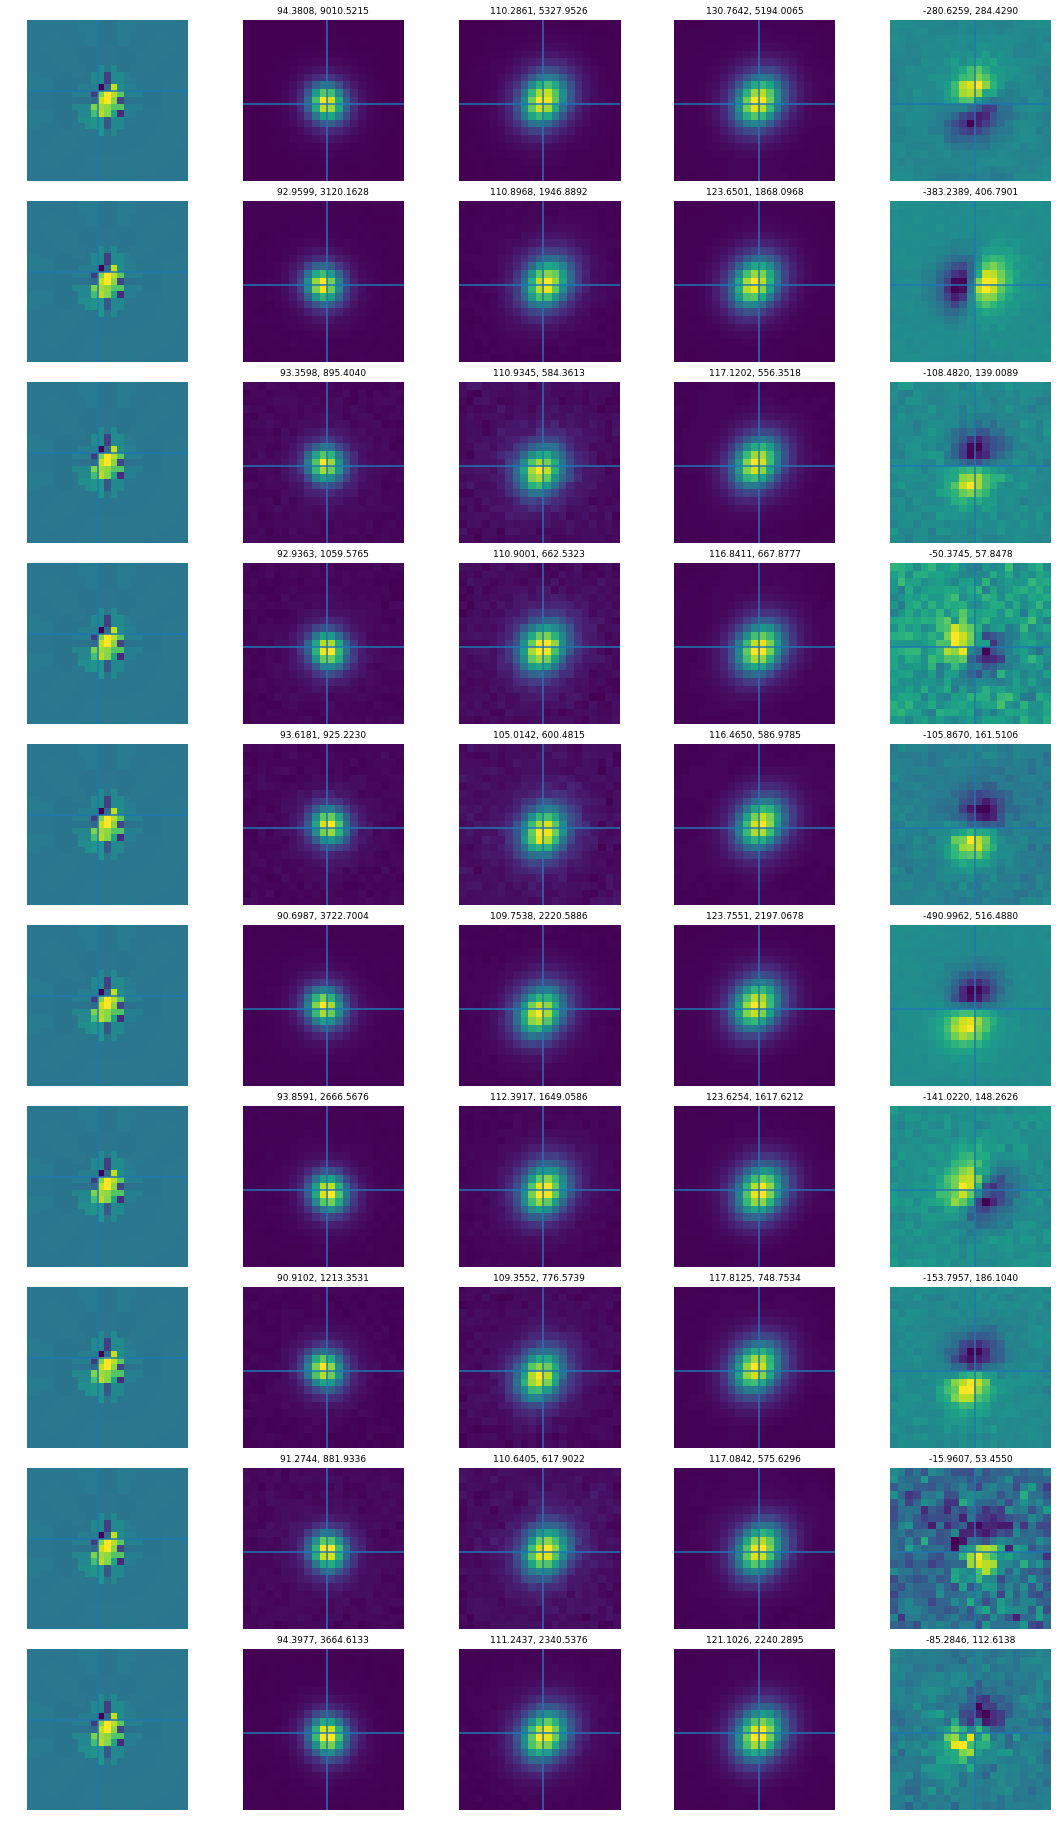

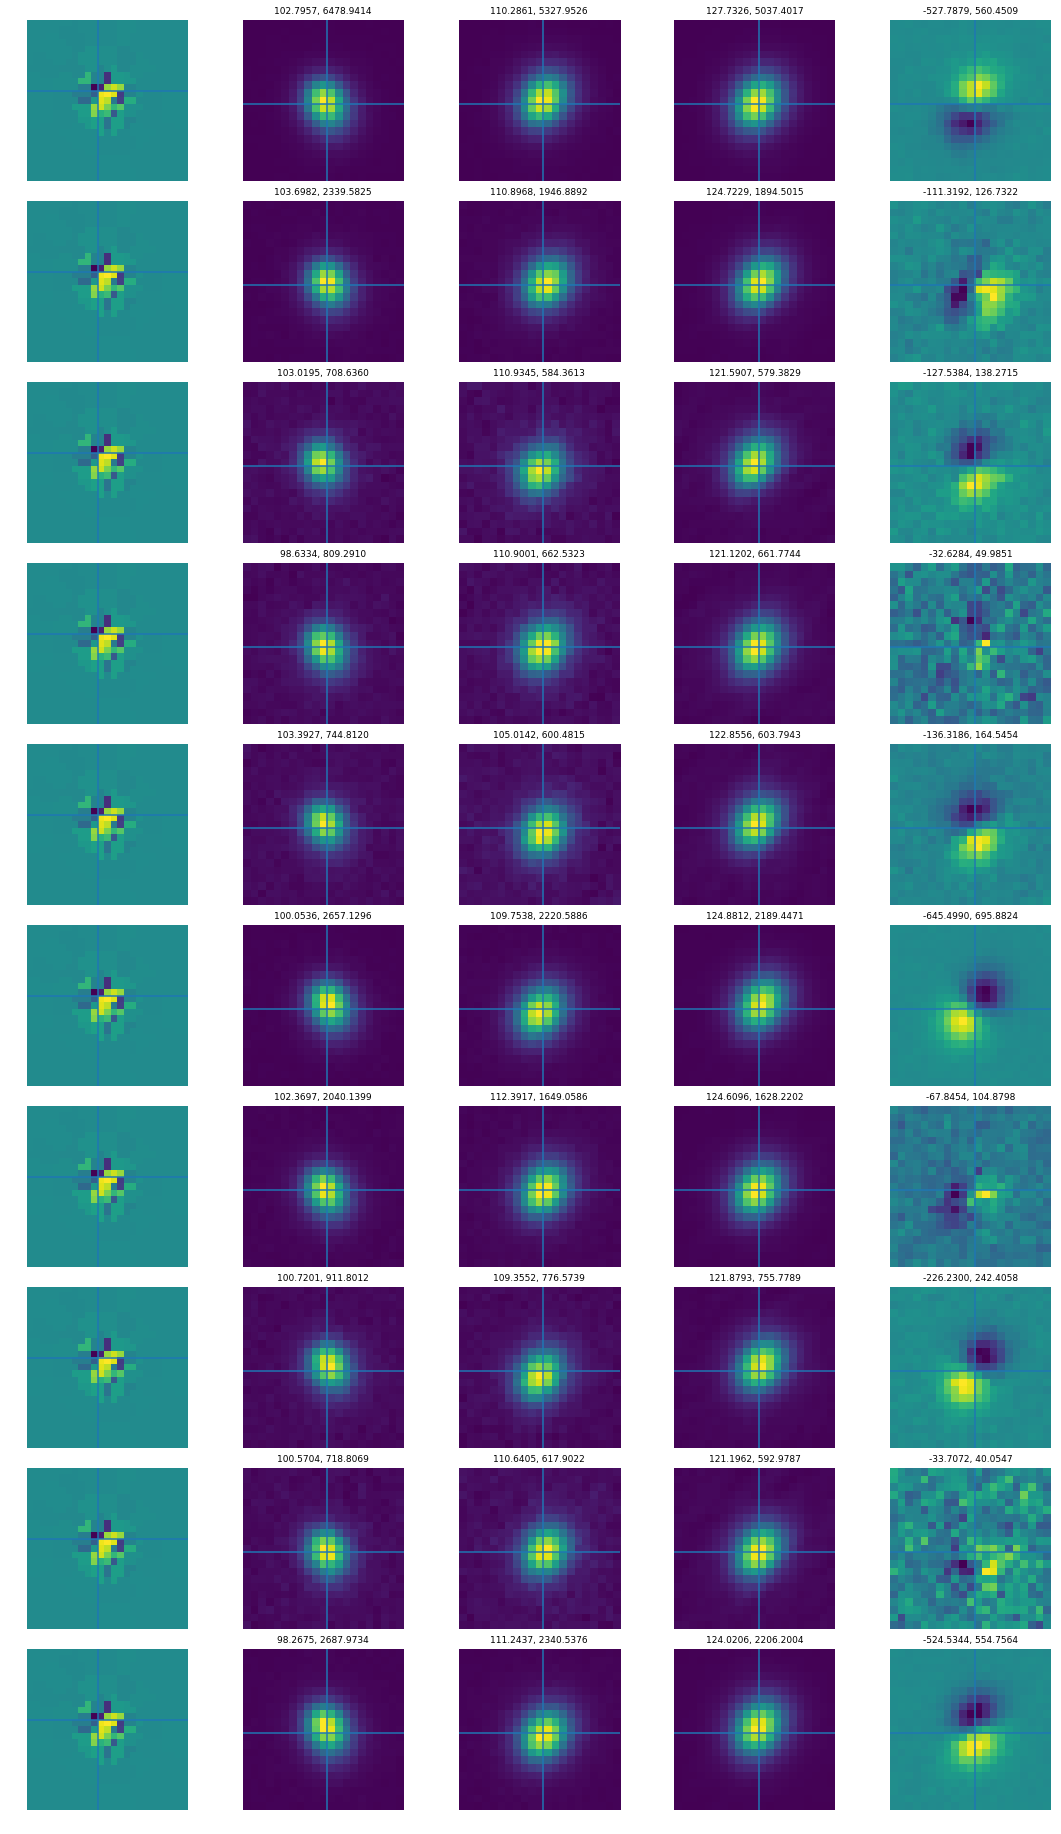

In [8]:
showstars(kern, stars, True)